In [1]:
# coding:utf-8
import math
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer  
%matplotlib inline
print "done"

done


# 1.数据处理

## 加载分词

In [2]:
# 停用词加载
import codecs
stopwords = []
with codecs.open('./stopwords_full.txt', 'r', 'utf-8') as f:
    stopwords = [i.rstrip() for i in f.readlines()]
    
# 新加停用词，使用tf-idf筛选
# with codecs.open('./stopwords_new.txt', 'r', 'utf-8') as f:
#     stopwords += [i.rstrip() for i in f.readlines()]
stopwords.append(' ')
stopwords.append(u'\x1d')
print('停用词个数：{}'.format(len(stopwords)))

stopwords_dict = dict(zip(stopwords, range(len(stopwords))))

# 结巴字典加载
jieba.load_userdict('./medical_jieba.dic')
print "done"

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


停用词个数：1895


Loading model cost 0.299 seconds.
Prefix dict has been built succesfully.


done


## 处理数据

In [3]:
# 读取数据，分词，储存
des_list = list()

with codecs.open('../data/traindata_all_processed.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
for line in tqdm.tqdm(contents):
    line_s = line.split('\t')
    if len(line_s) < 2:
        continue
    des = line_s[0]
    depart = line_s[1].strip()
    
    des_jieba = jieba.cut_for_search(des)
    des_final = u' '.join([j for j in des_jieba if (not stopwords_dict.has_key(j)) 
                              and (re.search(pattern=u'[\u4e00-\u9fa5]+', string=j))])
    # 分词后，疾病描述不能为空
    if not des_final=='':
        des_list.append((depart, des_final))
        
# 存储
with codecs.open('../data/search_appointments_split_raw.txt', 'wb', 'utf-8') as f:
    for (label, des) in des_list:
        w = u'{}\t{}\n'.format(label, des)
        f.write(w)
print ("分词数据保存成功")

100%|██████████| 246616/246616 [01:39<00:00, 2487.88it/s]


分词数据保存成功


In [4]:
# # 统计样本长度
# len_dict = dict()
# for label, des in des_list:
#     length = len(des.split(" "))
#     if len_dict.has_key(length):
#         len_dict[length] += 1
#     else:
#         len_dict[length] = 1
# for key in len_dict.keys():
#     print key, len_dict[key]

## 统计TF-IDF

In [5]:
# from collections import defaultdict

# alldata = defaultdict(list)

# with open("../data/search_appointments_split_raw.txt", 'rb') as f:
#     for aline in f.readlines():
#         lines = aline.split("\t")
#         alldata[lines[0]] += lines[1].split(' ')
        
# for key in alldata.keys():
#     alldata[key] = " ".join(alldata[key])
# vectorizer = CountVectorizer()
# transformer = TfidfTransformer()
# tfidf = transformer.fit_transform(vectorizer.fit_transform(alldata.values()))

# word = vectorizer.get_feature_names()
# print "done"

In [6]:
# threshhold = 400
# topDict = defaultdict(list)

# for i, key in enumerate(alldata.keys()):
#     # 筛选tf-idf高的词
#     sortIndex = (-tfidf[i].toarray()).argsort()[0]
#     for j, index in enumerate(sortIndex):
#         topDict[key].append(word[index])
#         if j == threshhold-1:
#             break
# # 打印看看
# # for key in topDict.keys():
# #     print "*"*40
# #     print key
# #     for word in topDict[key]:
# #         print word
# wordset = set([j for i in topDict.values() for j in i])
# count = dict()
# for aword in wordset:
#     count[aword] = 0
# for key, wordlist in topDict.items():
#     for aword in wordlist:
#         count[aword] += 1
# res = sorted(count.iteritems(), key=lambda item:item[1], reverse = True)
# for (a, b) in res:
#     print a
#     if b<30:
#         break

In [7]:
# cut_des_list = list()
# threshhold = 30
# with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
#     for aline in f.readlines():
#         line = aline.split('\t')
#         depart = line[0]
#         des = line[1].split(' ')
#         length = len(des)
#         if length >= threshhold:
#             rem = length % 30
            

## 处理数据（替换相似词）

In [ ]:
sub_dict = dict()
new_data = list()
with codecs.open('../word2vec/sub_dict.txt', 'rb', 'utf-8') as f:
    for line in f.readlines():
        line_s = line.split('\t')
        sub_word = line_s[0]
        sub_set = set(line_s[1].split(" "))
        sub_dict[sub_word] = sub_set

with codecs.open('../data/search_appointments_split_raw.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in tqdm.tqdm(contents):
            line_s = line.split('\t')
            department = line_s[0]
            description = line_s[1].split(" ")
            new_description = list()
            for aword in description:
                aword = aword.strip()
                found = False
                for sub_word in sub_dict.keys():
                    if aword in sub_dict[sub_word]:
                        new_description.append(sub_word)
                        found = True
                        break
                if not found:
                    new_description.append(aword)
            new_data.append((department, new_description))

            # 储存        
with codecs.open('../data/search_appointments_split.txt', 'wb', 'utf-8') as f:
    for (label, des) in new_data:
        des = [i.strip() for i in des]
        w = u'{}\t{}\n'.format(label, " ".join(des))
        f.write(w)
print "储存成功"

 35%|███▌      | 86819/246206 [09:25<17:09, 154.83it/s] 

# 2.筛选科室

## 二级科室

In [5]:
# 创建目录
if not os.path.exists('../data/depart'):
    os.makedirs('../data/depart')
if not os.path.exists('../data/depart_data'):
    os.makedirs('../data/depart_data')
if not os.path.exists('../data/model'):
    os.makedirs('../data/model')

In [6]:
# 二级科室划分训练集与数据集
def erji_department_s(deName):
    # 数据处理 分层 train/test
    SPLIT_RATE = 0.8
    label_index_list = list()
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(deName), 'rb', 'utf-8') as f:
        contents = f.readlines()
        descrip_data = contents
        for line in contents:
            line_s = line.split('\t')
            label_index_list.append(line_s[0].encode('utf-8'))

    label_dict = dict()
    for index in range(len(label_index_list)):
        label = label_index_list[index]

        if label_dict.has_key(label):
            label_dict[label].append(index)
        else:
            label_dict.setdefault(label, [index])
    train_list = list()
    test_list = list()
    train_num_dict = dict()
    # 设置是否过采样
    over_sampling = False

    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)

        llist = label_dict[label_aim]

        train_num_dict[label_aim] = int(SPLIT_RATE*len(llist))

    max_samp_num = max(train_num_dict.values())   

    print('二级科目数：{}'.format(len(label_dict.keys())))
    for index in range(len(label_dict.keys())):
        label_aim = '__label__'+str(index)
        llist = label_dict[label_aim]
        np.random.shuffle(llist)

        train_slen = train_num_dict[label_aim]
        for sindex in llist[:train_slen]:
            train_list.append(descrip_data[sindex])

        if over_sampling:
            over_count_need = (max_samp_num/train_slen-1)*train_slen
            over_count = 0
            over_indexs = np.random.randint(0, train_slen, over_count_need)
            for over_index in over_indexs:
                sindex = llist[over_index]
                train_list.append(descrip_data[sindex])

        for sindex in llist[train_slen:]:
            test_list.append(descrip_data[sindex])

    np.random.shuffle(train_list)
    np.random.shuffle(test_list)

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line)

    with codecs.open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line)
            
    # 训练集字典生成，以及测试集合词筛选
    # 到时候做 低频词筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.read()
        
    # 对训练集统计词
    train_countv = CountVectorizer()
    result_train_countv = train_countv.fit_transform([train_contents])

    train_vocabulary = train_countv.vocabulary_
    print('训练集词语数：{}'.format(len(train_countv.vocabulary_)))

    LESS_FRE_WORD = 0
    train_dictionary = list()

    #低频词筛选
    for word, value in train_vocabulary.iteritems():
        if result_train_countv[0, value] > LESS_FRE_WORD:
            train_dictionary.append(word.encode('utf-8'))

    print('低频词筛选后词语数：{}'.format(len(train_dictionary)))
    with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_dictionary:
            f.write(line.decode('utf-8')+'\n')
    train_dictionary = dict(zip(train_dictionary, range(len(train_dictionary))))


    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.read()
        
    # 对测试集统计词
    test_countv = CountVectorizer()
    result_test_countv = test_countv.fit_transform([test_contents])

    test_vocabulary = test_countv.vocabulary_
    print('测试集词语数：{}'.format(len(test_countv.vocabulary_))) 

    # 通过字典，分别对train数据集和test数据集筛选
    with open('../data/depart_data/search_appointments_split_train1_{}.txt'.format(deName), 'rb') as f:
        train_contents = f.readlines()
        print('筛选前训练集大小：{}'.format(len(train_contents)))
    with open('../data/depart_data/search_appointments_split_test1_{}.txt'.format(deName), 'rb') as f:
        test_contents = f.readlines()
        print('筛选前测试集大小：{}'.format(len(test_contents)))

    train_list = list()
    test_list = list()
    
    # 训练集
    for line in train_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            train_list.append('{}\t{}'.format(label, ' '.join(words)))

    # 测试集
    for line in test_contents:
        line_s = line.split('\t')
        label = line_s[0]
        words = [i.strip() for i in line_s[1].split(' ')]
        words = [i for i in words if train_dictionary.has_key(i)]
        if len(words) != 0:
            test_list.append('{}\t{}'.format(label, ' '.join(words)))

    print('筛选后训练集大小：{}'.format(len(train_list)))
    print('筛选后测试集大小：{}'.format(len(test_list)))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in train_list:
            f.write(line.decode('utf-8')+'\n')

    with codecs.open('../data/depart_data/search_appointments_split_test_{}.txt'.format(deName), 'wb', 'utf-8') as f:
        for line in test_list:
            f.write(line.decode('utf-8')+'\n')

In [7]:
# 二级科室模型训练
def fast_text_model(deName):           
    # set params
    with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(deName), 'rb') as f:
        content = f.readlines()
        count = len(content)
    
    lr = 0.3
    epoch = int(100*math.sqrt(200000/count))
    bucket = int(math.sqrt((float(count)/200000))*2000000)
    print deName, count, lr, epoch, bucket
    keshi = deName
    input_file = '../data/depart_data/search_appointments_split_train_{}.txt'.format(keshi)
    output = '../data/model/app_model_{}'.format(keshi)
    dim=50
    loss= 'hs'
    lr_update_rate = 98
    ws = 5
    min_count=2
    neg = 2
    word_ngrams= 5
    thread=5
    silent=1
    label_prefix='__label__'

    # Train the classifier
    classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                         lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                         min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                         thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)


    result = classifier_app.test(input_file)
    print('Train:')
    print('P@1:', result.precision)
    print('R@1:', result.recall)
    print('Number of examples:', result.nexamples)

    test_result = classifier_app.test('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi), 1)
    print('Test:')
    print('P@1:', test_result.precision)
    print('R@1:', test_result.recall)
    print('Number of examples:', test_result.nexamples)

    labels_right = []
    texts = []
    with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(keshi)) as fr:
        lines = fr.readlines()
    for line in lines:
        labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
        texts.append(line.split("\t")[1].decode("utf-8"))
    #     print labels
    #     print texts
    #     break
    labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
    # print labels_predict

    text_labels = list(set(labels_right))
    text_predict_labels = list(set(labels_predict))
    # print text_predict_labels
    # print text_labels

    A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
    B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
    C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
    for i in range(0,len(labels_right)):
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1

    # print A 
    # print B
    # print C
    select_department_dict = pkl.load(open('../data/depart/department_{}.pkl'.format(keshi), 'rb'))
    select_de_tup = select_department_dict.items()
    new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

    rlist = list()
    #计算准确率，召回率，F值
    for key in B:
        if int(B[key]) == 0:
            r = 0
        else:
            r = round(A[key] / float(B[key]), 3)
        if int(C[key]) == 0:
            p = 0
        else:
            p = round(A[key] / float(C[key]), 3)
        if (p+r) == 0:
            f1 = 0
        else:
            f1 = round(p * r * 2 / (p + r), 3)
        rlist.append([key,new_dict.get(key),r,p,f1,int(B[key])])
#         print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)
    rdataf = pd.DataFrame(rlist, columns=['Key', 'Department', 'Recall', 'Precision', 'F1', 'Support'])
    print(rdataf)

In [8]:
# 数据处理，根据一级科目筛选，并保存label对应关系
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    
    des_list = list()
    select_depart_dict = dict()

    with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
        contents = f.readlines()
        for line in contents:
            line_s = line.split('\t')
            department = line_s[0].encode('utf-8')
            
            if department in select_department:
                if not select_depart_dict.has_key(department):
                    select_depart_dict[department] = len(select_depart_dict.keys())
                des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))

    #保存科室与label对应关系
    if len(select_depart_dict.keys()) == 0:
        continue
        
    store_tup = sorted(select_depart_dict.items(), key=lambda item:item[1])
    with codecs.open('../data/depart/department_{}.txt'.format(fdepart_name), 'wb','utf-8') as f:
        for depart, index in store_tup:
            f.write(('{}\t{}\n'.format(depart, index)).decode('utf-8'))

    pkl.dump(select_depart_dict, open('../data/depart/department_{}.pkl'.format(fdepart_name), 'wb'))

    # 存储
    with codecs.open('../data/depart_data/search_appointments_select_split_{}.txt'.format(fdepart_name), 'w', 'utf-8') as f:
        for (label, des) in des_list:
            f.write(u'{}\t{}'.format(label, des))  
    print fdepart, "done"
print "done"

内科 done
儿科 done
外科 done
妇产科 done
肿瘤科 done
五官科 done
皮肤性病科 done
骨科 done
血液科 done
感染科 done
心理健康 done
康复科 done
中医科 done
男科 done
疼痛科 done
风湿免疫科 done
急诊科 done
done


In [9]:
# 划分训练集测试集
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        fdepart_name = line.split('：')[2].strip()

        print('*'*40)
        print(line.split('：')[0].strip())
        erji_department_s(fdepart_name)
print "done"

****************************************
内科
二级科目数：7
训练集词语数：38275
低频词筛选后词语数：38275
测试集词语数：17677
筛选前训练集大小：44351
筛选前测试集大小：11094
筛选后训练集大小：44318
筛选后测试集大小：11085
****************************************
儿科
二级科目数：2
训练集词语数：14150
低频词筛选后词语数：14150
测试集词语数：6352
筛选前训练集大小：10005
筛选前测试集大小：2503
筛选后训练集大小：9998
筛选后测试集大小：2501
****************************************
外科
二级科目数：12
训练集词语数：34790
低频词筛选后词语数：34790
测试集词语数：16455
筛选前训练集大小：42671
筛选前测试集大小：10675
筛选后训练集大小：42630
筛选后测试集大小：10665
****************************************
妇产科
二级科目数：2
训练集词语数：15426
低频词筛选后词语数：15426
测试集词语数：7078
筛选前训练集大小：14383
筛选前测试集大小：3597
筛选后训练集大小：14377
筛选后测试集大小：3595
****************************************
肿瘤科
二级科目数：1
训练集词语数：10787
低频词筛选后词语数：10787
测试集词语数：4926
筛选前训练集大小：5662
筛选前测试集大小：1416
筛选后训练集大小：5660
筛选后测试集大小：1416
****************************************
五官科
二级科目数：3
训练集词语数：22691
低频词筛选后词语数：22691
测试集词语数：10516
筛选前训练集大小：21572
筛选前测试集大小：5396
筛选后训练集大小：21562
筛选后测试集大小：5394
****************************************
皮肤性病科
二级科目数：2
训练集词语数：14710
低频词筛选后词语数：14710
测试

In [10]:
# 二级模型训练与测试
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    
    # 二级科目只有一个，无需分类
    if len(sdepart_list)==1:
        print fdepart, "pass"
        continue
        
    fdepart_name = line_s[2].strip()
    print('*'*40)
    print(fdepart)
    fast_text_model(fdepart_name)
    print('\n')
print "done"

****************************************
内科
neike 44318 0.3 200 941466
Train:
('P@1:', 0.9986912766821607)
('R@1:', 0.9986912766821607)
('Number of examples:', 44318)
Test:
('P@1:', 0.8156066756878665)
('R@1:', 0.8156066756878665)
('Number of examples:', 11085)
  Key Department  Recall  Precision     F1  Support
0   1       消化内科   0.873      0.798  0.834     1797
1   0       内分泌科   0.843      0.822  0.832     1756
2   3       普通内科   0.482      0.668  0.560     1209
3   2        肾内科   0.866      0.898  0.882     1192
4   5       呼吸内科   0.880      0.877  0.878     1799
5   4       神经内科   0.847      0.790  0.818     1798
6   6      心血管内科   0.828      0.812  0.820     1534


****************************************
儿科
erke 9998 0.3 447 447168
Train:
('P@1:', 0.9996999399879976)
('R@1:', 0.9996999399879976)
('Number of examples:', 9998)
Test:
('P@1:', 0.9168332666933227)
('R@1:', 0.9168332666933227)
('Number of examples:', 2501)
  Key Department  Recall  Precision     F1  Support
0   1     

# 一级科室

In [11]:
# 生成一级科目label对应文件
# import json
first_secondDepart = dict()
second_firstDepart = dict()

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        fdepart = line_s[0]
        sdepart_list = line_s[1].split('，')
        sdepart_list = [i.strip() for i in sdepart_list]
        first_secondDepart.setdefault(fdepart, sdepart_list)
        for sdepart in sdepart_list:
            second_firstDepart.setdefault(sdepart, fdepart)

#print json.dumps(first_secondDepart, encoding="UTF-8", ensure_ascii=False)
#print json.dumps(second_firstDepart, encoding="UTF-8", ensure_ascii=False)
            
select_department_zip = zip(first_secondDepart.keys(), range(len(first_secondDepart.keys())))

with codecs.open('../data/department.txt', 'wb','utf-8') as f:
    for (d, i) in select_department_zip:
        f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

select_department_dict = dict(select_department_zip)
pkl.dump(select_department_dict, open('../data/department.pkl', 'wb'))

print "done"

done


In [12]:
# # 统计一下数据中病人科室分布情况

# WORDS_COUNT = 700
# department_counts = appointment_data.department_std.value_counts()
# print '二级科室数：' , len(department_counts)
# print department_counts
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len(department_counts[department_counts>WORDS_COUNT]))

# select_department = department_counts[department_counts>WORDS_COUNT].keys()
# black_list = ['特诊部','未定义','其他']
# white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
#              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('./data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('./data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [13]:
# print len(second_firstDepart)
# print len(select_department_dict)

In [14]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('./data/department_freq_select.pkl', 'rb'))
# first_department_dict = pkl.load(open('./data/department.pkl', 'rb'))

# des_list = list()

# with codecs.open('./data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department) and second_firstDepart.has_key(department):
#             first_depart = second_firstDepart[department]
#             des_list.append(('__label__{}'.format(first_department_dict[first_depart]), u''.join(line_s[1:])))

# # 存储
# with codecs.open('./data/search_appointments_freq_select_split.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label, des))
# print "done"

In [15]:
## 测试jieba功能
# print(appointment_data.disease_desc.loc[91717])


# aaa = jieba.cut(appointment_data.disease_desc.loc[91717])
# for i in aaa:
#     if not stopwords_dict.has_key(i):
#         print(i)
#         print([i])
# # print(' '.join(aaa))
# print(' '.join([j.strip() for j in aaa if j not in stopwords_dict]))

# print(des_list[91717][1])
# # appointment_data.disease_desc.loc[91717]

# FastText数据集

In [16]:
import fasttext
from sklearn.cross_validation import train_test_split

/usr/share/Anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [17]:
# 合并二级科目训练集测试集，生成一级科目训练集测试集
first_label = pkl.load(open('../data/department.pkl', 'rb'))

with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    des_dict_train = dict()
    des_dict_test = dict()
    des_dict_test_final = dict()
    for line in contents:
        depart_name_ch = line.split('：')[0].strip()
        depart_name_py = line.split('：')[2].strip()
        second_label = pkl.load(open('../data/depart/department_{}.pkl'.format(depart_name_py), 'rb'))
        second_label = dict(zip(second_label.values(), second_label.keys()))
        label = '__label__' + str(first_label[depart_name_ch])
        
        
        # 训练集合并
        des_list_train = list()
        with open('../data/depart_data/search_appointments_split_train_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_train.append(line.split('\t')[1])
        
        np.random.shuffle(des_list_train)
        des_dict_train[label] = des_list_train
        
        
        #测试集合并
        des_list_test = list()
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                des_list_test.append(line.split('\t')[1])
                
        np.random.shuffle(des_list_test)
        des_dict_test[label] = des_list_test
        
        #测试集合并（最终用）
        with open('../data/depart_data/search_appointments_split_test_{}.txt'.format(depart_name_py)) as f:
            for line in f.readlines():
                this_label = line.split('\t')[0].replace('__label__', '')
                second_depart = second_label[int(this_label)]
                if not des_dict_test_final.has_key(second_depart):
                    des_dict_test_final[second_depart] = [line.split('\t')[1]]
                else:
                    des_dict_test_final[second_depart].append(line.split('\t')[1])

train_list = list()
test_list = list()

for key in des_dict_train.keys():
        for des in des_dict_train[key]:
            train_list.append('{}\t{}'.format(key, des))

for key in des_dict_test.keys():
        for des in des_dict_test[key]:
            test_list.append('{}\t{}'.format(key, des))
            
np.random.shuffle(train_list)
np.random.shuffle(test_list)
            
# 存储
with codecs.open('../data/search_appointments_split_train.txt', 'wb', 'utf-8') as f:
    for line in train_list:
        f.write(line.decode('utf-8'))
        

with codecs.open('../data/search_appointments_split_test.txt', 'wb', 'utf-8') as f:
    for line in test_list:
        f.write(line.decode('utf-8'))
        
with codecs.open('../data/search_appointments_split_test_final.txt', 'wb', 'utf-8') as f:
    for key in des_dict_test_final.keys():
        for des in des_dict_test_final[key]:
            f.write("{}\t{}".format(key, des).decode('utf-8'))
        
print "done"

done


In [18]:
print "训练集大小："
for key in des_dict_train.keys():
    print key, len(des_dict_train[key])
    
print "测试集大小："
for key in des_dict_test.keys():
    print key, len(des_dict_test[key])
print "done"

训练集大小：
__label__8 42630
__label__9 4788
__label__0 21562
__label__1 10379
__label__2 9998
__label__3 4031
__label__4 7187
__label__5 44318
__label__6 4621
__label__7 14377
__label__12 7189
__label__13 965
__label__10 5660
__label__11 4624
__label__16 5049
__label__14 4560
__label__15 4851
测试集大小：
__label__8 10665
__label__9 1198
__label__0 5394
__label__1 2597
__label__2 2501
__label__3 1008
__label__4 1795
__label__5 11085
__label__6 1156
__label__7 3595
__label__12 1799
__label__13 240
__label__10 1416
__label__11 1157
__label__16 1261
__label__14 1138
__label__15 1212
done


# FastText

In [19]:
# set params
keshi = 'yiji'
input_file = '../data/search_appointments_split_train.txt'
output = '../data/model/app_model'
dim=50
lr=0.3
loss= 'hs'
lr_update_rate = 98
epoch=100
ws = 5
min_count=2
neg = 2
word_ngrams= 5
bucket=2000000
thread=10
silent=1
label_prefix='__label__'

# Train the classifier
classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                     lr_update_rate = lr_update_rate, loss = loss, neg = neg,
                                     min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                     thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)

result = classifier_app.test(input_file)
print('Train:')
print('P@1:', result.precision)
print('R@1:', result.recall)
print('Number of examples:', result.nexamples)

test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
print('Test:')
print('P@1:', test_result.precision)
print('R@1:', test_result.recall)
print('Number of examples:', test_result.nexamples)

labels_right = []
texts = []
with open('../data/search_appointments_split_test.txt') as fr:
    lines = fr.readlines()
for line in lines:
    labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
    texts.append(line.split("\t")[1].decode("utf-8"))
#     print labels
#     print texts
#     break
labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# print labels_predict

text_labels = list(set(labels_right))
text_predict_labels = list(set(labels_predict))
# print text_predict_labels
# print text_labels

A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
B = dict.fromkeys(text_labels,0)  #测试数据集中各个类的数目
C = dict.fromkeys(text_labels,0)  #预测结果中各个类的数目
for i in range(0,len(labels_right)):
    B[labels_right[i]] += 1
    C[labels_predict[i]] += 1
    if labels_right[i] == labels_predict[i]:
        A[labels_right[i]] += 1

# print A 
# print B
# print C
select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup = select_department_dict.items()
new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))
print "done"

Train:
('P@1:', 0.9976573893866019)
('R@1:', 0.9976573893866019)
('Number of examples:', 196789)
Test:
('P@1:', 0.7545360342970925)
('R@1:', 0.7545360342970925)
('Number of examples:', 49217)
done


In [22]:
## 计算准确率，召回率，F值
depart_name = []
precision = []
recall = []
f1_measure = []
for key in B:
    r = float(A[key]) / float(B[key])
    recall.append(r)
    p = float(A[key]) / float(C[key])
    precision.append(p)
    f1 = p * r * 2 / (p + r)
    f1_measure.append(f1)
    depart_name.append(new_dict.get(key))
    print "%2s: %-16s \t p:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),p,r,f1)
for index in range(len(depart_name)):
    depart_name[index] = depart_name[index].decode('utf-8')
print "done"

11: 血液科        	 p:0.771503	r:0.767502	f:0.769497	
10: 肿瘤科        	 p:0.710767	r:0.713277	f:0.712020	
13: 康复科        	 p:0.725581	r:0.650000	f:0.685714	
12: 骨科           	 p:0.622830	r:0.658143	f:0.640000	
15: 风湿免疫科  	 p:0.716195	r:0.751650	f:0.733494	
14: 感染科        	 p:0.692586	r:0.673111	f:0.682709	
16: 男科           	 p:0.641892	r:0.678033	f:0.659468	
 1: 皮肤性病科  	 p:0.749599	r:0.720447	f:0.734734	
 0: 五官科        	 p:0.851750	r:0.857434	f:0.854582	
 3: 急诊科        	 p:0.777324	r:0.754960	f:0.765979	
 2: 儿科           	 p:0.671801	r:0.732507	f:0.700842	
 5: 内科           	 p:0.762908	r:0.761119	f:0.762012	
 4: 中医科        	 p:0.609739	r:0.495265	f:0.546572	
 7: 妇产科        	 p:0.832839	r:0.859249	f:0.845838	
 6: 疼痛科        	 p:0.496285	r:0.577855	f:0.533973	
 9: 心理健康     	 p:0.768627	r:0.818030	f:0.792560	
 8: 外科           	 p:0.794391	r:0.770183	f:0.782100	
done


In [24]:
#! /usr/bin/env python 
# -*- coding: utf-8 -*- 
## 绘图函数
from matplotlib.font_manager import FontProperties
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.sans-serif'] = ['SimHei']   
matplotlib.rcParams['font.family']='sans-serif'  

# font = FontProperties(fname=r"/mnt/c/Windows/Fonts/simsun.ttc", size=10) 

def draw_bar(x, y, heading):
    plt.figure(figsize=(9,3),dpi=100)
    plt.bar(range(len(x)), y, tick_label=x)
    plt.xticks(rotation=60, fontsize=12)
#     ax=plt.gca()
#     ax.set_xticklabels(x, fontproperties=font)
#     plt.title(heading, fontproperties=font)
#     plt.xlabel(u'科室')
    plt.ylabel(heading, fontsize=15)
#     plt.ylabel(heading, fontproperties=font)
    plt.grid(True)
    plt.show()

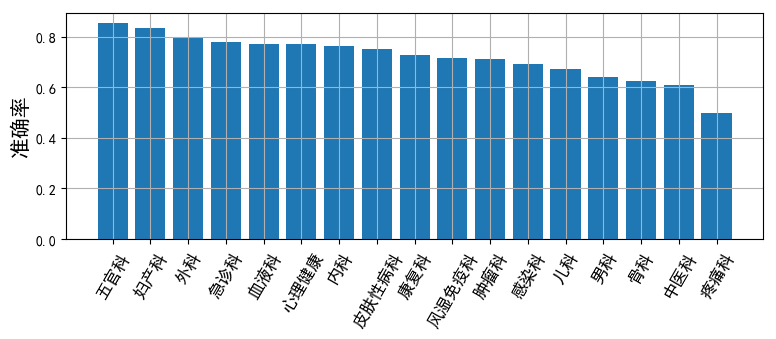

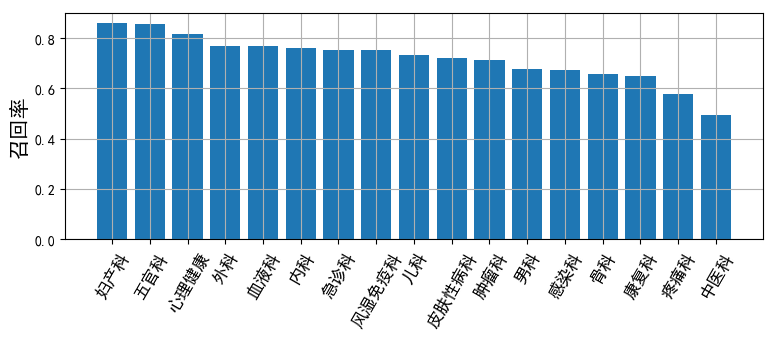

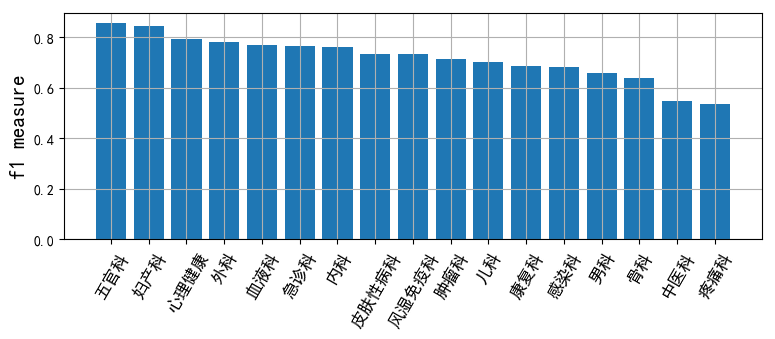

In [25]:
## 绘图   
precision_dict = dict(zip(depart_name, precision))
precision_list = sorted(precision_dict.items(), key=lambda item:item[1], reverse=True)
recall_dict = dict(zip(depart_name, recall))
recall_list = sorted(recall_dict.items(), key=lambda item:item[1], reverse=True)
f1_dict = dict(zip(depart_name, f1_measure))
f1_list = sorted(f1_dict.items(), key=lambda item:item[1], reverse=True)
draw_bar([i[0] for i in precision_list], [i[1] for i in precision_list], u'准确率')
draw_bar([i[0] for i in recall_list], [i[1] for i in recall_list], u'召回率')
draw_bar([i[0] for i in f1_list], [i[1] for i in f1_list], 'f1 measure')

# 4.预测

In [26]:
# coding:utf-8
import numpy
import jieba
import jieba.analyse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cPickle as pkl
import re
import os
import tqdm
import codecs
import fasttext
from sklearn.feature_extraction.text import CountVectorizer
%matplotlib inline
print "done"

done


## 4.1 数据预处理

In [27]:
# # 统计科室数据量 过滤样本不足的科室

# WORDS_COUNT = 1000
# depart_count = dict()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if not depart_count.has_key(department):
#             depart_count[department] = 1
#         else:
#             depart_count[department] += 1

# depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
    
# print '数据超过%d的科室数：%d' %(WORDS_COUNT, len([count for (depart, count) in depart_count if count > WORDS_COUNT]))

# select_department = [depart for (depart, count) in depart_count if count > WORDS_COUNT]
# # black_list = ['特诊部','未定义','其他']
# # white_list = ['心血管内科', '感染内科', '过敏反应科', '普通内科', '呼吸内科', '肝胆内科', '血液内科', '泌尿内科',
# #              '风湿免疫科', '消化内科', '神经内科', '内分泌科', '肾内科']
# # select_department = list(set(select_department)-set(black_list))
# # select_department = list(set(select_department)&set(white_list))
# select_department_zip = zip(select_department, range(len(select_department)))

# with codecs.open('../data/department_freq_select.txt', 'wb','utf-8') as f:
#     for (d, i) in select_department_zip:
#         f.write(('{}\t{}\n'.format(d, i)).decode('utf-8'))

# select_department_dict = dict(select_department_zip)
# pkl.dump(select_department_dict, open('../data/department_freq_select.pkl', 'wb'))
# print "有效科室数：", len(select_department_dict)
# for i in select_department_dict:
#      print i

# print "done"

In [28]:
# # label加载，筛选低于一定数据量的科室
# select_department_dict = pkl.load(open('../data/department_freq_select.pkl', 'rb'))

# des_list = list()

# with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
#     contents = f.readlines()
#     for line in contents:
#         line_s = line.split('\t')
#         department = line_s[0].encode('utf-8')
        
#         if select_department_dict.has_key(department):
#             des_list.append((department, u''.join(line_s[1:])))

# # 存储
# with codecs.open('../data/final_test.txt', 'w', 'utf-8') as f:
#     for (label, des) in des_list:
#         f.write(u'{}\t{}'.format(label.decode('utf-8'), des))
# print "done"

## 4.2 测试

In [29]:
#加载一级科目训练集词汇
train_dictionary_first = list()
with codecs.open('../data/word_dictionary.txt', 'rb', 'utf-8') as f:
    cont = f.readlines()
    for line in cont:
        train_dictionary_first.append(line.strip())
train_dictionary_first = dict(zip(train_dictionary_first, range(len(train_dictionary_first))))

#加载一级科目对应关系
select_department_dict_first = pkl.load(open('../data/department.pkl', 'rb'))
select_de_tup_first = select_department_dict_first.items()
new_dict_first = dict(zip([str(x[1]) for x in select_de_tup_first], [x[0] for x in select_de_tup_first]))


#加载二级科目训练集词汇
train_dictionary_second = dict()
new_dict_second = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('：')
        deName = line_s[2].strip()
        train_dictionary_second[deName] = list()
        new_dict_second[deName] = dict()
        
        #加载二级科目对应关系
        with codecs.open('../data/depart_data/word_dictionary_{}.txt'.format(deName), 'rb', 'utf-8') as f:
            cont = f.readlines()
            for line in cont:
                train_dictionary_second[deName].append(line.strip())
        train_dictionary_second[deName] = dict(zip(train_dictionary_second[deName], range(len(train_dictionary_second[deName]))))
        
        select_department_dict_second = pkl.load(open('../data/depart/department_{}.pkl'.format(deName), 'rb'))
        select_de_tup_second = select_department_dict_second.items()
        new_dict_second[deName] = dict(zip([str(x[1]) for x in select_de_tup_second], [x[0] for x in select_de_tup_second]))

print 'done' 

done


In [30]:
# 二层模型
def first_part_decide(model, sentence, prothresh = 0.05):    
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_first.has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_first.get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

def second_part_decide(model, sentence, deName, prothresh = 0.05):
    words = [i.strip() for i in sentence.split(' ')]
    words = [i for i in words if train_dictionary_second[deName].has_key(i)]
    words = ' '.join(words)
    if len(words) != 0:
        result = model.predict_proba([words], 5)[0]
        return [(new_dict_second[deName].get(i[0].replace("__label__","")), i[1], i[0]) for i in result if i[1]>prothresh]
    else:
#         print('未出现字典中的关键词,无法判定')
        return None

In [31]:
# 模型加载
first_departPath = '../data/model/app_model.bin'

first_departModel = fasttext.load_model(first_departPath)

second_departModel_dict = dict()
with codecs.open('../data/department_seg.txt', 'rb') as f:
    contents = f.readlines()
modelList = dict()
for line in contents:
    line_s = line.split('：')
    fdepart = line_s[0]
    sdepart_list = line_s[1].split('，')
    if len(sdepart_list) == 1:
        continue
    select_department = [i.strip() for i in sdepart_list]
    fdepart_name = line_s[2].strip()
    modelList[fdepart] = fdepart_name
    secondmodel = fasttext.load_model('../data/model/app_model_{}.bin'.format(fdepart_name))
    second_departModel_dict[fdepart] = secondmodel

print "done"

done


In [32]:
# 加载数据
des_list = list()
label_list = list()
# # 过滤后的科室
# with codecs.open('../data/final_test.txt', 'rb', 'utf-8') as f:
# 未过滤的科室
with codecs.open('../data/search_appointments_split_test_final.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        label = line_s[0].encode('utf-8')
        des = line_s[1]
        label_list.append(label)
        des_list.append(des)
print 'done'

done


In [33]:
labels_right = list()
texts = list()
labels_predict = list()

for des_index in tqdm.tqdm(range(len(des_list))):
    des = des_list[des_index]
    first_result = first_part_decide(first_departModel, des)
    if first_result == None:
        continue
    optim_depart = ''
    optim_pro = 0.0
    for (fdepart, fpro, fkey) in first_result:
        if second_departModel_dict.has_key(fdepart):
            second_result = second_part_decide(second_departModel_dict[fdepart], des, modelList[fdepart])
            if second_result == None:
                continue
            for (sdepart, spro, skey) in second_result:
                pro = spro
                if pro > optim_pro:
                    optim_depart = sdepart
                    optim_pro = pro
        else:
            if fpro > optim_pro:
                optim_depart = fdepart
                optim_pro = fpro
            
#     print(optim_fdepart)
    if optim_depart!= '':
        labels_predict.append(optim_depart)
        texts.append(des)
        labels_right.append(label_list[des_index])

# for index in range(len(test_data_data)):
#     print('描述：{}'.format(test_data_data[index]))
#     print('科室：{}'.format(res_list[index]))
#     print('\n')

100%|██████████| 49217/49217 [00:04<00:00, 9869.93it/s] 


In [34]:
# for i in range(100) :
#     print texts[i]
#     print labels_right[i]
#     print labels_predict[i]
#     print('*'*40)

In [35]:
all_label = list()
with open('../data/department_seg.txt') as f:
    content = f.readlines()
    for aline in content:
        sec_depart = aline.split("：")[1].split("，")
        all_label += sec_depart

A = dict.fromkeys(all_label,0)  #预测正确的各个类的数目
B = dict.fromkeys(all_label,0)  #测试数据集中各个类的数目
C = dict.fromkeys(all_label,0)  #预测结果中各个类的数目

for i in range(0,len(labels_right)):
    try:
        B[labels_right[i]] += 1
        C[labels_predict[i]] += 1
        if labels_right[i] == labels_predict[i]:
            A[labels_right[i]] += 1
    except:
        print labels_right[i]
        

#计算准确率，召回率，F值
for key in B:
#     #低频科目筛选
#     if B[key] == 0:
#         continue
    r = float(A[key]) / float(B[key])
    p = float(A[key]) / float(C[key])
    f1 = p * r * 2 / (p + r)
    print " %-16s\t p:%f\t r:%f\t f:%f\t" % (key, p, r, f1)

        

 眼科          	 p:0.815354	 r:0.903782	 f:0.857294	
 风湿免疫科 	 p:0.805061	 r:0.708746	 f:0.753839	
 心理科       	 p:0.565217	 r:0.701878	 f:0.626178	
 急诊科       	 p:0.868895	 r:0.670635	 f:0.756999	
 性病科       	 p:0.735777	 r:0.722084	 f:0.728867	
 精神科       	 p:0.613060	 r:0.814767	 f:0.699666	
 脊柱外科    	 p:0.655510	 r:0.748369	 f:0.698869	
 妇科          	 p:0.703370	 r:0.823791	 f:0.758833	
 胸外科       	 p:0.390625	 r:0.221239	 f:0.282486	
 普外科       	 p:0.547131	 r:0.523529	 f:0.535070	
 肿瘤科       	 p:0.805808	 r:0.627119	 f:0.705322	
 骨科          	 p:0.716322	 r:0.558644	 f:0.627733	
 康复科       	 p:0.826389	 r:0.495833	 f:0.619792	
 内分泌科    	 p:0.714797	 r:0.682232	 f:0.698135	
 感染科       	 p:0.807169	 r:0.573814	 f:0.670776	
 乳腺外科    	 p:0.832034	 r:0.853198	 f:0.842483	
 消化内科    	 p:0.553664	 r:0.651642	 f:0.598671	
 疼痛科       	 p:0.555218	 r:0.474048	 f:0.511433	
 整形外科    	 p:0.608247	 r:0.341040	 f:0.437037	
 血管外科    	 p:0.775240	 r:0.756155	 f:0.765579	
 男科          	 p:0.740541	 r:0

In [36]:
import pandas as pd
df = pd.DataFrame(index = B, columns=['precision','recall','f1-measure'])

for key in B:
    r = float(A[key]) / float(B[key])
    p = float(A[key]) / float(C[key])
    f1 = p * r * 2 / (p + r)
    df.loc[key] = [p, r, f1]

df.to_csv("result_using_cut_for_search_without_sim_replace.csv", encoding = "utf-8")

In [37]:
df

,precision,recall,f1-measure
眼科,0.815354,0.903782,0.857294
风湿免疫科,0.805061,0.708746,0.753839
心理科,0.565217,0.701878,0.626178
急诊科,0.868895,0.670635,0.756999
性病科,0.735777,0.722084,0.728867
精神科,0.61306,0.814767,0.699666
脊柱外科,0.65551,0.748369,0.698869
妇科,0.70337,0.823791,0.758833
胸外科,0.390625,0.221239,0.282486
普外科,0.547131,0.523529,0.53507


In [196]:
df_old = pd.read_csv("result_using_cut_for_search.csv")
res = df_new = pd.read_csv("result_using_tfidf.csv")

res['precision'] -= df_old['precision']
res['recall'] -= df_old['recall']
res['f1-measure'] -= df_old['f1-measure']
res

,Unnamed: 0,precision,recall,f1-measure
0,眼科,0.016590,-0.001718,0.008392
1,风湿免疫科,-0.019759,-0.028878,-0.025052
2,心理科,-0.085105,-0.005363,-0.052610
3,急诊科,-0.007277,-0.018831,-0.014827
4,性病科,-0.022014,-0.013665,-0.017971
5,精神科,-0.032797,-0.006477,-0.023603
6,脊柱外科,-0.028276,0.013048,-0.010222
7,妇科,0.019233,0.017592,0.018565
8,胸外科,-0.072381,-0.088496,-0.088975
9,普外科,-0.022277,-0.027156,-0.024675


In [19]:
#加载label与科室对应关系
first = pkl.load(open('../data/department.pkl', 'rb'))
first_dict = dict(zip(first.values(), first.keys()))

In [34]:
my_des = ['肚子 肚子疼 晚上 肚子 肚子疼 伴随 呕吐','一直流鼻涕','胃疼']
my_result = first_departModel.predict(my_des)
for res in my_result:
    print first_dict[int(re.sub("\D", "", res[0].encode('utf-8')))]

儿科
外科
内科


In [103]:
# result = classifier_app.test(input_file)
# print('P@1:', result.precision)
# print('R@1:', result.recall)
# print('Number of examples:', result.nexamples)

In [58]:
# test_result = classifier_app.test('../data/search_appointments_split_test.txt', 1)
# print('P@1:', test_result.precision)
# print('R@1:', test_result.recall)
# print('Number of examples:', test_result.nexamples)

('P@1:', 0.7042519145045149)
('R@1:', 0.7042519145045149)
('Number of examples:', 17498)


In [118]:
# labels_right = []
# texts = []
# with open('../data/search_appointments_split_test.txt') as fr:
#     lines = fr.readlines()
# for line in lines:
#     labels_right.append(line.split("\t")[0].rstrip().replace("__label__",""))
#     texts.append(line.split("\t")[1].decode("utf-8"))
# #     print labels
# #     print texts
# #     break
# labels_predict = [e[0] for e in classifier_app.predict(texts)] #预测输出结果为二维形式
# # print labels_predict

# text_labels = list(set(labels_right))
# text_predict_labels = list(set(labels_predict))
# # print text_predict_labels
# # print text_labels

# A = dict.fromkeys(text_labels,0)  #预测正确的各个类的数目
# B = dict.fromkeys(text_labels,0)   #测试数据集中各个类的数目
# C = dict.fromkeys(text_labels,0) #预测结果中各个类的数目
# for i in range(0,len(labels_right)):
#     B[labels_right[i]] += 1
#     C[labels_predict[i]] += 1
#     if labels_right[i] == labels_predict[i]:
#         A[labels_right[i]] += 1

# # print A 
# # print B
# # print C
# select_department_dict = pkl.load(open('../data/department.pkl', 'rb'))
# select_de_tup = select_department_dict.items()
# new_dict = dict(zip([str(x[1]) for x in select_de_tup], [x[0] for x in select_de_tup]))

# #计算准确率，召回率，F值
# for key in B:
#     r = float(A[key]) / float(B[key])
#     p = float(A[key]) / float(C[key])
#     f1 = p * r * 2 / (p + r)
#     print "%s:%s\tp:%f\tr:%f\tf:%f\t" % (key,new_dict.get(key),r,p,f1)

        

{'24': 23, '25': 95, '26': 67, '27': 24, '20': 21, '21': 394, '22': 41, '23': 338, '28': 450, '29': 57, '1': 66, '0': 701, '3': 22, '2': 91, '5': 32, '4': 1528, '7': 86, '6': 329, '9': 36, '8': 647, '11': 182, '10': 108, '13': 138, '12': 983, '15': 36, '14': 52, '17': 401, '16': 59, '33': 577, '32': 156, '31': 43, '30': 889, '35': 61, '34': 43, '19': 31, '18': 551}
{'24': 178, '25': 170, '26': 278, '27': 353, '20': 258, '21': 720, '22': 414, '23': 416, '28': 769, '29': 224, '1': 167, '0': 777, '3': 153, '2': 635, '5': 129, '4': 1930, '7': 326, '6': 904, '9': 135, '8': 850, '11': 356, '10': 291, '13': 298, '12': 1263, '15': 430, '14': 137, '17': 545, '16': 135, '33': 767, '32': 456, '31': 141, '30': 1137, '35': 471, '34': 123, '19': 137, '18': 844}
{u'24': 88, u'25': 198, u'26': 226, u'27': 178, u'20': 110, u'21': 793, u'22': 170, u'23': 388, u'28': 979, u'29': 155, u'1': 147, u'0': 846, u'3': 122, u'2': 370, u'5': 138, u'4': 2304, u'7': 285, u'6': 902, u'9': 111, u'8': 1030, u'11': 424

In [126]:
dimlist = [20, 50, 100]
word_ngramslist = [5, 10]
lrlist = [0.1, 0.3, 0.5]
# set params
input_file = '../data/search_appointments_split_train.txt'
output = 'app_model'
# dim=20
# lr=0.5
loss= 'hs'
lr_update_rate = 98
epoch=200
ws = 5
min_count=2
neg = 2
# word_ngrams= 5
bucket=2000000
thread=5
silent=1
label_prefix='__label__'
for dim in dimlist:
    for word_ngrams in word_ngramslist:
        for lr in lrlist:
            print('dim:', dim)
            print('word_ngrams:', word_ngrams)
            print('lr:', lr)
            # Train the classifier
            classifier_app = fasttext.supervised(input_file, output, dim=dim, lr=lr, epoch=epoch,
                                                 min_count=min_count, word_ngrams=word_ngrams, bucket=bucket,
                                                 thread=thread, silent=silent, label_prefix=label_prefix, ws=ws)
            result = classifier_app.test(input_file)
            print('P@1:', result.precision)
            print('R@1:', result.recall)
            print('Number of examples:', result.nexamples)
            
            test_result = classifier_app.test('../data/search_appointments_split_test.txt')
            print('P@1:', test_result.precision)
            print('R@1:', test_result.recall)
            print('Number of examples:', test_result.nexamples)
            print('-'*20)
            print('\n')

('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811160837544385)
('R@1:', 0.9811160837544385)
('Number of examples:', 155741)
('P@1:', 0.56568689726858)
('R@1:', 0.56568689726858)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.3)
('P@1:', 0.981032611836318)
('R@1:', 0.981032611836318)
('Number of examples:', 155741)
('P@1:', 0.5681700063521395)
('R@1:', 0.5681700063521395)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.5)
('P@1:', 0.981250923006787)
('R@1:', 0.981250923006787)
('Number of examples:', 155741)
('P@1:', 0.5700179014840908)
('R@1:', 0.5700179014840908)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('word_ngrams:', 5)
('lr:', 0.1)
('P@1:', 0.9811610301718879)
('R@1:', 0.9811610301718879)
('Number of examples:', 155741)
('P@1:', 0.5670728186175434)
('R@1:', 0.5670728186175434)
('Number of examples:', 17317)
--------------------


('dim:', 20)
('w

KeyboardInterrupt: 

In [47]:
from sklearn.feature_extraction.text import CountVectorizer

In [48]:
with open('../data/search_appointments_split.txt', 'rb') as f:
    contents = f.read()
countv = CountVectorizer()

In [49]:
new_countv = countv.fit_transform([contents])

In [50]:
print(new_countv.shape)
# print(countv.get_feature_names())
# with codecs.open('../data/search_words_fre.txt', 'wb', 'utf-8') as f:
#     for key in countv.vocabulary_.keys(): 
#         f.write(u'{}\t{}\n'.format(key, new_countv[0, countv.vocabulary_[key]]))

(1, 59409)


In [19]:
depart_count = dict()
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department = line_s[0].encode('utf-8')
        if department=="心":
            print line_s[1].encode('utf-8')
        if not depart_count.has_key(department):
            depart_count[department] = 1
        else:
            depart_count[department] += 1

depart_count = sorted(depart_count.items(), key=lambda item:item[1], reverse=True)
# print "总科室数：", len(depart_count)
# for (depart, count) in depart_count:
#     print depart, count
seta = set()
setb = set()
for (depart, count) in depart_count:
    seta.add(depart)
with open('../data/department_seg.txt', 'rb') as f:
    content = f.readlines()
    for aline in content:
        for depart in aline.split("：")[1].split("，"):
            setb.add(depart)

for item in setb-seta:
    print item

In [2]:
# 使用word2vec模型，过滤相似词
sim_dict = dict()
with open("../word2vec/sim_dict.txt", "rb") as f:
    contents = f.readlines()
    for aline in contents:
        word = aline.split("\t")[0]
        sim_list = [aword for aword in aline.split("\t")[1].split(" ")]
        sim_dict[word] = set(sim_list)

7517


In [ ]:
with codecs.open('../data/search_appointments_split.txt', 'rb', 'utf-8') as f:
    contents = f.readlines()
    for line in contents:
        line_s = line.split('\t')
        department =3 line_s[0].encode('utf-8')
        des = line_s[1].split(" ")
        
        for word in des:
            if sim_dict.has_key(word):
                
        if department in select_department:
            if not select_depart_dict.has_key(department):
                select_depart_dict[department] = len(select_depart_dict.keys())
            des_list.append(('__label__{}'.format(select_depart_dict[department]), u''.join(line_s[1:])))